# Import Packages

In [357]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from dotenv import load_dotenv   # <- helper for .env files
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import Metadata
#Set plot style
plt.style.use("seaborn-v0_8")


# Connect to Neon DB &  Load data

In [358]:
load_dotenv()
DB_URL = os.getenv("DATABASE_URL")
# !!!
engine = create_engine(DB_URL)

query = """
SELECT "timestamp", "part_id", "reading"
FROM "catdc_data_feed"
WHERE "state"='RUNNING';
"""


# df_test = pd.read_sql(query, engine)
# print(df_test)

df_long = pd.read_sql(query, engine)

df_train = df_long.pivot_table(index="timestamp", columns="part_id", values="reading", aggfunc="mean")

df_train.columns = [f"Axis #{i}" for i in df_train.columns]
df_train.reset_index(inplace=True)
df_train.rename(columns={"timestamp": "Time"}, inplace=True)

# fill missing values
df_train.fillna(0, inplace=True)

#convert time to datetime

df_train["Time"] = pd.to_datetime(df_train["Time"])

# Column lists

axis_cols = [col for col in df_train.columns if col.startswith("Axis #")]
# time_col = ["Time"]

# Preview first 5 rows

df_train.head()



,Time,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8
0,2022-10-17 12:18:23.660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-10-17 12:18:25.472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-10-17 12:18:27.348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-10-17 12:18:29.222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-10-17 12:18:31.117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [359]:
# Fill missing values
df_train.fillna(0, inplace=True)

# --- Filter out rows where all Axis readings are zero ---
axis_cols = [col for col in df_train.columns if col.startswith("Axis #")]
df_train_nonzero = df_train[(df_train[axis_cols] != 0).any(axis=1)]

# Use filtered DataFrame for regression, normalization, residuals, etc.
df_train = df_train_nonzero.copy()

# Optional: keep a copy of the full DataFrame if you want to plot all points including zeros
df_train_full = df_train_nonzero.copy()  # for visualization only

df_train.head()

,Time,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8
30,2022-10-17 12:19:20.136,0.0,3.0,4.0,0.0,1.0,1.0,4.0,0.0
31,2022-10-17 12:19:22.005,7.0,30.0,17.0,5.0,6.0,5.0,0.0,0.0
32,2022-10-17 12:19:27.952,0.0,11.0,3.0,2.0,4.0,5.0,4.0,0.0
33,2022-10-17 12:19:29.911,2.0,20.0,11.0,2.0,4.0,1.0,0.0,0.0
34,2022-10-17 12:19:31.969,4.0,2.0,5.0,1.0,1.0,1.0,0.0,0.0


# Normalize data (min-max)

In [360]:
scaler_minmax = MinMaxScaler()
df_norm = df_train.copy()
df_norm[axis_cols] = scaler_minmax.fit_transform(df_train[axis_cols])

df_norm.head()


,Time,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8
30,2022-10-17 12:19:20.136,0.000000,0.06,0.097561,0.000000,0.052632,0.052632,0.5,0.0
31,2022-10-17 12:19:22.005,0.318182,0.60,0.414634,0.333333,0.315789,0.263158,0.0,0.0
32,2022-10-17 12:19:27.952,0.000000,0.22,0.073171,0.133333,0.210526,0.263158,0.5,0.0
33,2022-10-17 12:19:29.911,0.090909,0.40,0.268293,0.133333,0.210526,0.052632,0.0,0.0
34,2022-10-17 12:19:31.969,0.181818,0.04,0.121951,0.066667,0.052632,0.052632,0.0,0.0


# Standardize (Z-scores)


In [361]:
scaler_std = StandardScaler()

df_std = df_train.copy()
df_std[axis_cols] = scaler_std.fit_transform(df_train[axis_cols])

# scale time to mins\

df_std["time_min"] = (df_std["Time"] - df_std["Time"].min()).dt.total_seconds() / 60
df_std.head()


,Time,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8,time_min
30,2022-10-17 12:19:20.136,-0.588082,-0.892864,-0.622926,-0.793678,-0.629359,-0.255368,0.518266,-0.275803,0.000000
31,2022-10-17 12:19:22.005,1.451799,2.416537,1.498417,1.528199,1.155277,1.153454,-0.774996,-0.275803,0.031150
32,2022-10-17 12:19:27.952,-0.588082,0.087699,-0.786106,0.135073,0.441423,1.153454,0.518266,-0.275803,0.130267
33,2022-10-17 12:19:29.911,-0.005259,1.190833,0.519336,0.135073,0.441423,-0.255368,-0.774996,-0.275803,0.162917
34,2022-10-17 12:19:31.969,0.577564,-1.015435,-0.459745,-0.329302,-0.629359,-0.255368,-0.774996,-0.275803,0.197217


# Regression Models (Time > Axis

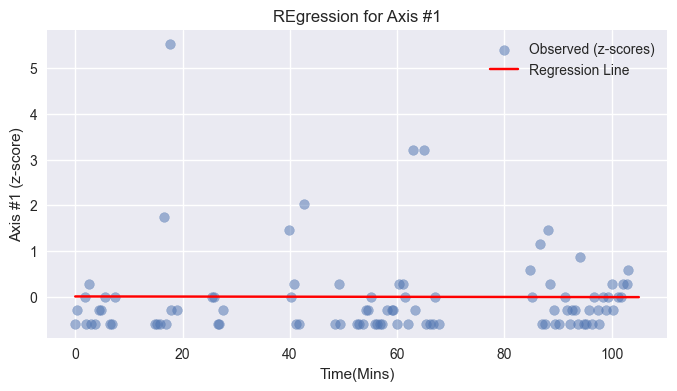

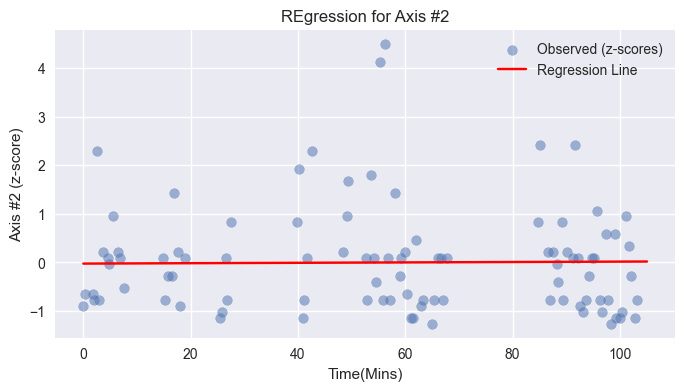

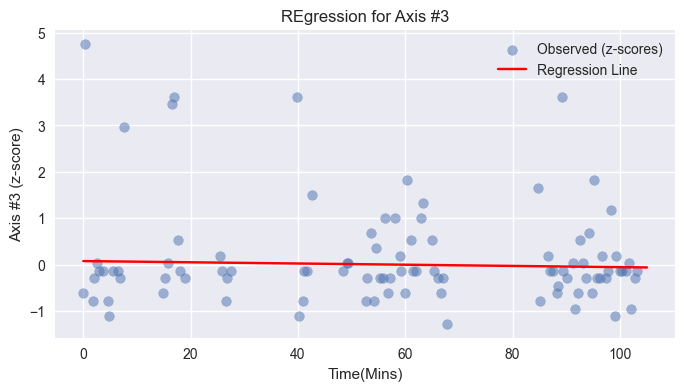

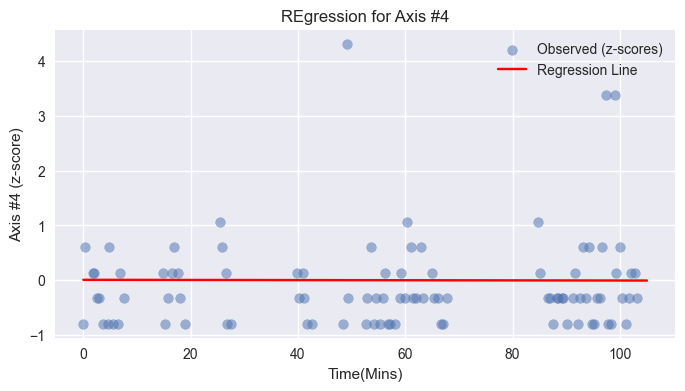

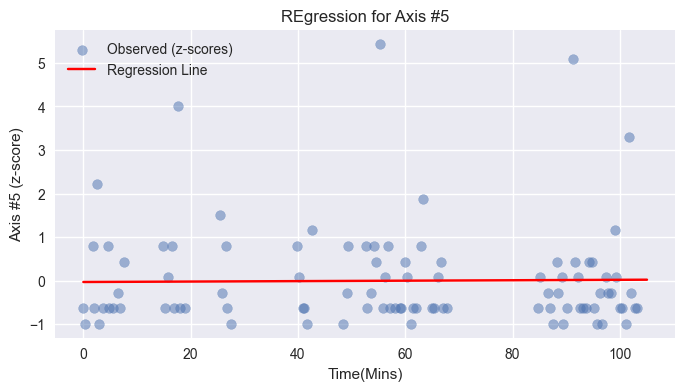

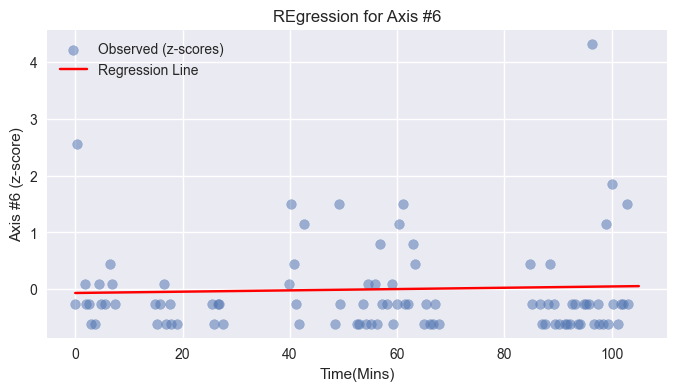

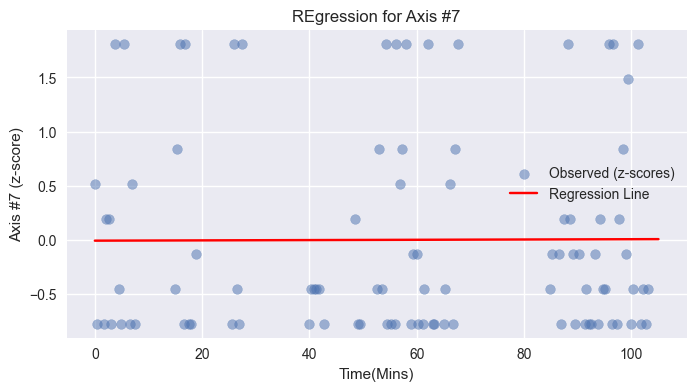

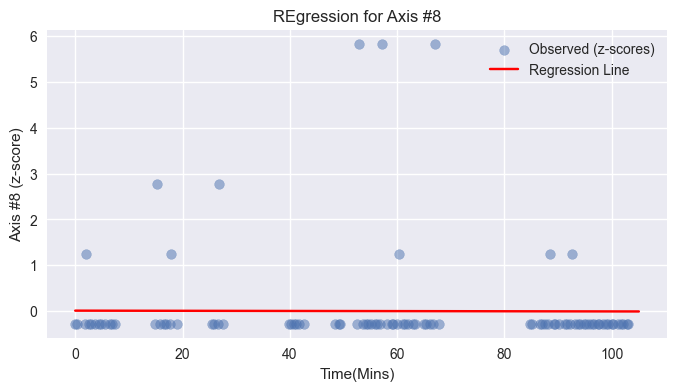

In [362]:
#Try plotting throyugh the standrize score

models = {}
residuals = {}

for axis in axis_cols:
    x = df_std[["time_min"]].values
    y = df_std[axis].values

    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)

    models[axis] = model
    residuals[axis] = y - y_pred
    #sample points for every 10th low for less clutter
    df_plot = df_std.iloc[::10]




# df_train["time_min"] = (df_train["Time"] - df_train["Time"].min()).dt.total_seconds()
#
# models = {}
# residuals = {}
#
# for axis in axis_cols:
#     x = df_train[["time_min"]].values
#     y = df_train[axis].values
#
#     model = LinearRegression().fit(x,y)
#     y_pred = model.predict(x)
#
#     models[axis] = model
#     residuals[axis] = y - y_pred
#
#     # Plot the regression
    plt.figure(figsize=(8,4))

    plt.scatter(df_plot["time_min"], df_plot[axis], alpha=0.5, label="Observed (z-scores)" )
    plt.plot(df_std["time_min"], y_pred, color="red", label="Regression Line")

    plt.title(f"REgression for {axis}")
    plt.xlabel("Time(Mins)")
    plt.ylabel(f"{axis} (z-score)")
    plt.legend()
    plt.show()


# Generate Synthetic Testing Data

In [363]:
# We must define the synthtic time range (1 min interveals)
#Uses the standardized data for synthetic creation
start_time = df_train["Time"].min()
end_time = df_train["Time"].max() + pd.Timedelta(minutes = 30)
time_index = pd.date_range(start=start_time, end=end_time, freq="1min")

# make the synthetic dataframe

df_synth = pd.DataFrame({"Time": time_index})

df_synth["time_min"] = (df_synth["Time"] - df_train["Time"].min()).dt.total_seconds() /60

# Gerenate the synthetic readings
for axis in axis_cols:
    model = models[axis]
    y_synth = model.predict(df_synth[["time_min"]].values)
    df_synth[axis] = y_synth

print(df_synth.head())





                     Time  time_min   Axis #1   Axis #2   Axis #3   Axis #4  \
0 2022-10-17 12:19:20.136       0.0  0.008212 -0.023241  0.075121  0.007177   
1 2022-10-17 12:20:20.136       1.0  0.008069 -0.022838  0.073816  0.007052   
2 2022-10-17 12:21:20.136       2.0  0.007926 -0.022434  0.072511  0.006928   
3 2022-10-17 12:22:20.136       3.0  0.007784 -0.022030  0.071206  0.006803   
4 2022-10-17 12:23:20.136       4.0  0.007641 -0.021626  0.069901  0.006678   

    Axis #5   Axis #6   Axis #7   Axis #8  
0 -0.028837 -0.066217 -0.007699  0.009587  
1 -0.028336 -0.065066 -0.007566  0.009420  
2 -0.027835 -0.063916 -0.007432  0.009253  
3 -0.027334 -0.062766 -0.007298  0.009087  
4 -0.026833 -0.061616 -0.007164  0.008920  


# Residual on Syntehtic Data


In [364]:
residuals_synth = {}

for axis in axis_cols:
    x_test = df_synth[["time_min"]].values
    y_pred = models[axis].predict(x_test)
    residuals_synth[axis] = df_synth[axis] - y_pred

Residual Analysis

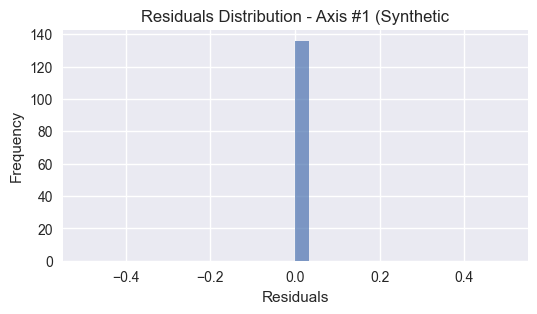

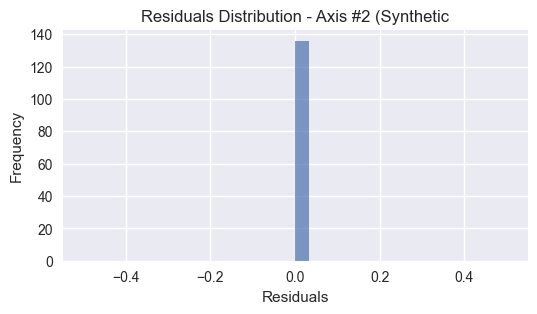

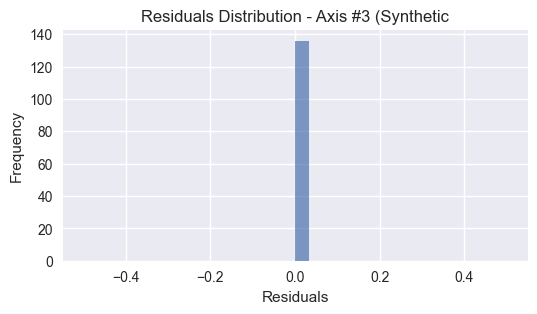

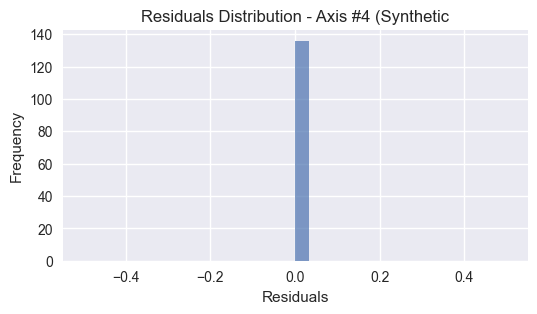

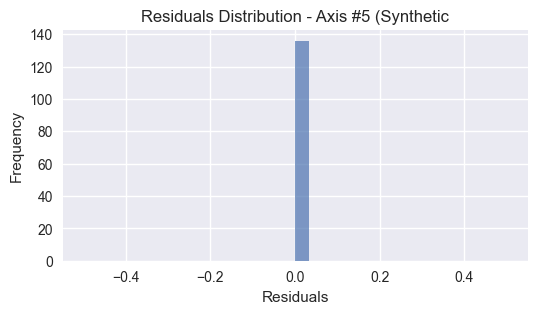

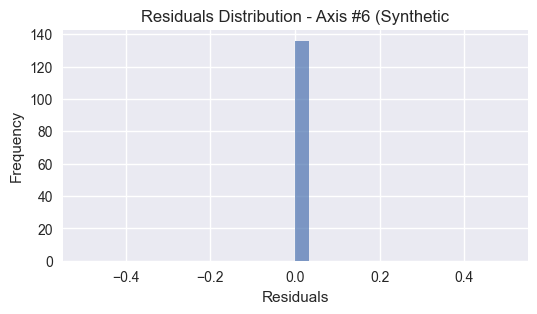

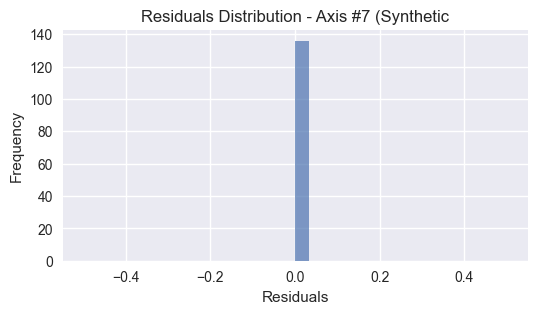

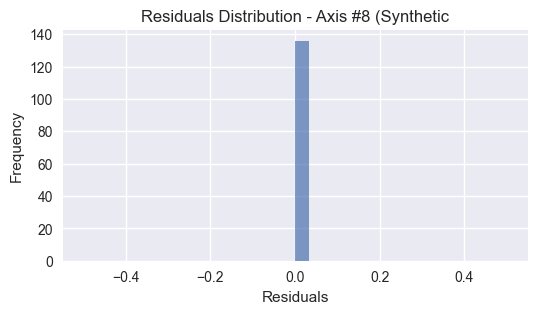

In [365]:
for axis in axis_cols:


    plt.figure(figsize=(6,3))
    plt.hist(residuals_synth[axis], bins=30, alpha=0.7)
    plt.title(f"Residuals Distribution - {axis} (Synthetic")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()

Define Min Max

In [366]:
thresholds = {}
T_seconds = 5 # the number of miminmum contious time for alert or error

for axis in axis_cols:
    res = residuals_synth[axis]

    minC = np.percentile(res, 90) # 90th percinetile deviation sends alert
    maxC = np.percentile(res, 95) # 95th percentile deviation sends error
    T = 5

    thresholds[axis] = {"MinC": minC, "MaxC": maxC, "T": T_seconds}

thresholds

{'Axis #1': {'MinC': np.float64(0.0), 'MaxC': np.float64(0.0), 'T': 5},
 'Axis #2': {'MinC': np.float64(0.0), 'MaxC': np.float64(0.0), 'T': 5},
 'Axis #3': {'MinC': np.float64(0.0), 'MaxC': np.float64(0.0), 'T': 5},
 'Axis #4': {'MinC': np.float64(0.0), 'MaxC': np.float64(0.0), 'T': 5},
 'Axis #5': {'MinC': np.float64(0.0), 'MaxC': np.float64(0.0), 'T': 5},
 'Axis #6': {'MinC': np.float64(0.0), 'MaxC': np.float64(0.0), 'T': 5},
 'Axis #7': {'MinC': np.float64(0.0), 'MaxC': np.float64(0.0), 'T': 5},
 'Axis #8': {'MinC': np.float64(0.0), 'MaxC': np.float64(0.0), 'T': 5}}

# Detect Alerts  & Errors

In [367]:

alerts = []

for axis in axis_cols:

    res = residuals_synth[axis]
    MinC = thresholds[axis]["MinC"]
    MaxC = thresholds[axis]["MaxC"]
    T = thresholds[axis]["T"]


    above_min = res > MinC
    above_max = res > MaxC

    #!!! Helper to find continous periods
    def find_periods(mask):
        periods = []
        start_idx = None
        for i, val in enumerate(mask):
            if val and start_idx is None:
                start_idx = i
            elif not val and start_idx is not None:
                duration = df_synth["time_min"].ilock[i-1] - df_synth["time_min"].iloc[start_idx]
                if duration*60 >=T:
                    periods.append((df_synth["Time"].iloc[start_idx], df_synth["Time"].ilock[i-1]))
                    return periods


    alerts += [(axis, "ALERT", start, end) for start, end in find_periods(above_min)]
    alerts += [(axis, "ERROR", start, end) for start, end in find_periods(above_max)]

# Convert to DataFrame
alerts_df = pd.DataFrame(alerts, columns=["Axis", "Type", "Start Time", "End Time"])
alerts_df.head()


    # if not above_min.empty:
    #     alerts.append((axis, "ALERT", above_min[time_col].iloc[0]))
    # if not above_max.empty:
    #     alerts.append((axis,"error", above_max[time_col].iloc[0]))
    #
    #
    # pd.DataFrame(alerts, columns = ["Axis", "Type", "Time"])

TypeError: 'NoneType' object is not iterable

# Overlay alerts or Errors on plot

In [ ]:
for axis in axis_cols:
    x_test = df_synth["time_min"]
    y_pred = models[axis].predict(x_test.values.reshape(-1,1))

    plt.figure(figsize=(10,4))
    plt.scatter(x_test, df_synth[axis], alpha=0.5, label="Observed (Synthetic)")
    plt.plot(x_test, y_pred, color="red", label="Regression Line")

    # Overlay alerts/errors
    for _, row in alerts_df[alerts_df["Axis"]==axis].iterrows():
        start = (row["Start Time"] - df_train["Time"].min()).total_seconds()/60
        end = (row["End Time"] - df_train["Time"].min()).total_seconds()/60
        color = "yellow" if row["Type"]=="ALERT" else "orange"
        plt.axvspan(start, end, color=color, alpha=0.3, label=row["Type"])

    plt.title(f"Regression with Alerts/Errors - {axis}")
    plt.xlabel("Time (Minutes)")
    plt.ylabel(f"{axis} (z-score)")
    plt.legend()
    plt.show()


# Save Results

In [103]:
    # Local save to the results

    pd.DataFrame.from_dict(thresholds, orient="index").to_csv("data/results_thresholds.csv")
    alerts_df.to_csv("data/results_detected_events.csv", index=False)

# Explinatnion